In [1]:
import sys
sys.path.insert(1, 'source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'source/data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'target'        : False,
    'roi'           : False,
    'brain'         : False,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [],
    'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25'],
    'balance_data'  : True,
    'debug'         : False,
    'targets_all'   : False,
    'collapse_max'  : False,
    'extras'        : None,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_20481024512256128_0001_CCE_10_1_1_0_0_0_0_None___1_1_1_sourcedata__k5_b25k7_b25k9_b25k11_b25k13_b25_0_0_42_None_08_0_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1601030, 460)
(1601030, 8)
validation
(238212, 460)
(238212, 8)
test
(194359, 460)
(194359, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath='source/data/models/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 2048)              944128    


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 3732360 (14.24 MB)


Trainable params: 3732360 (14.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists('source/data/models/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave('source/data/models/{}.pkl'.format(HASH), history.history)

model.load_weights('source/data/models/{}.weights.h5'.format(HASH))

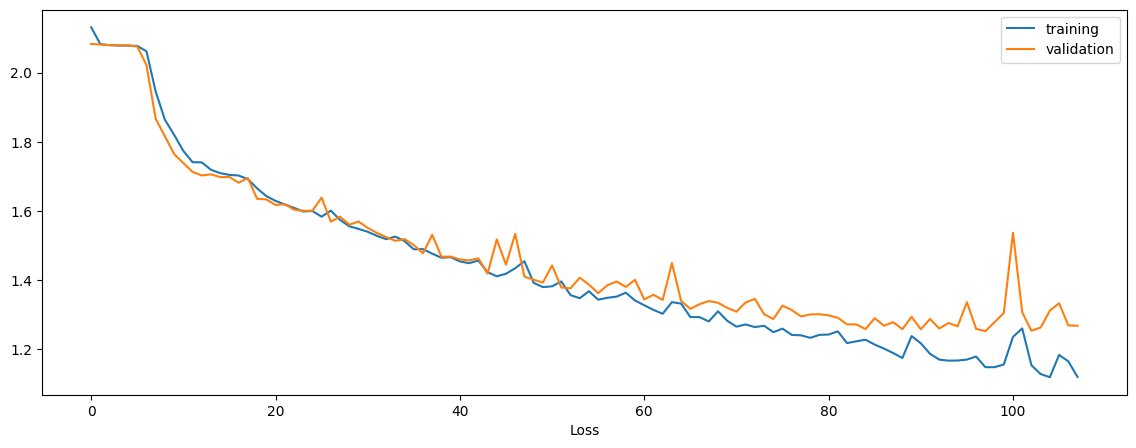

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad('source/data/models/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.5677176567584618


0.5069056134871459


0.45595007177439684


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.4455985551946456


0.4161192808600586


0.40656085700886135


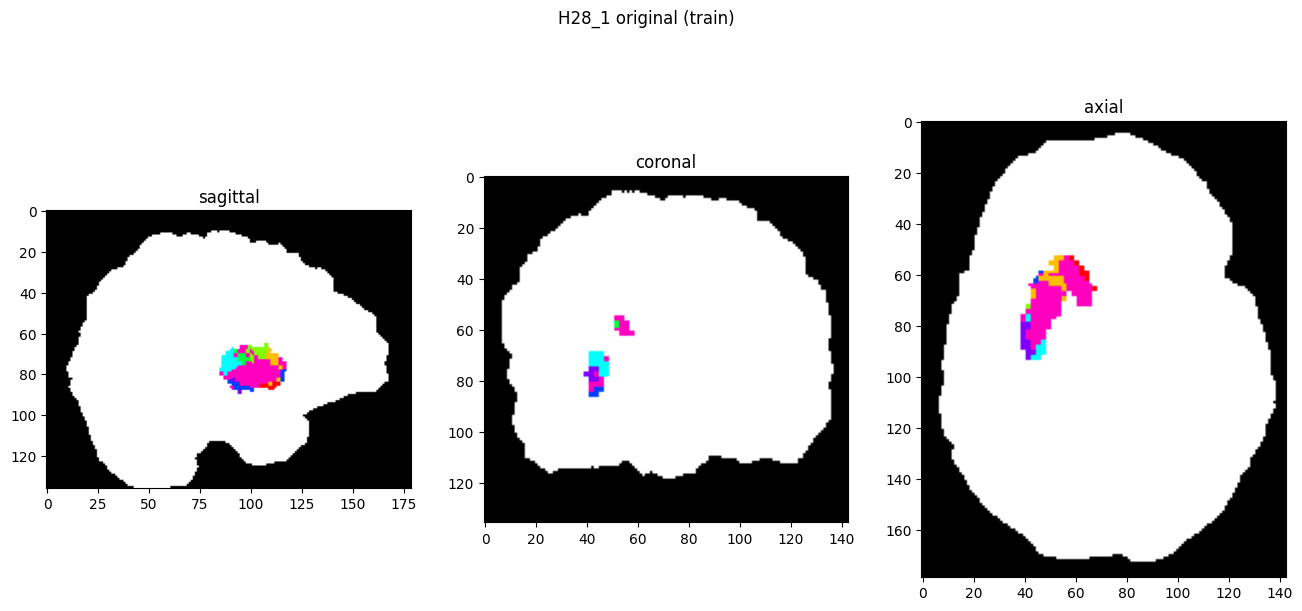

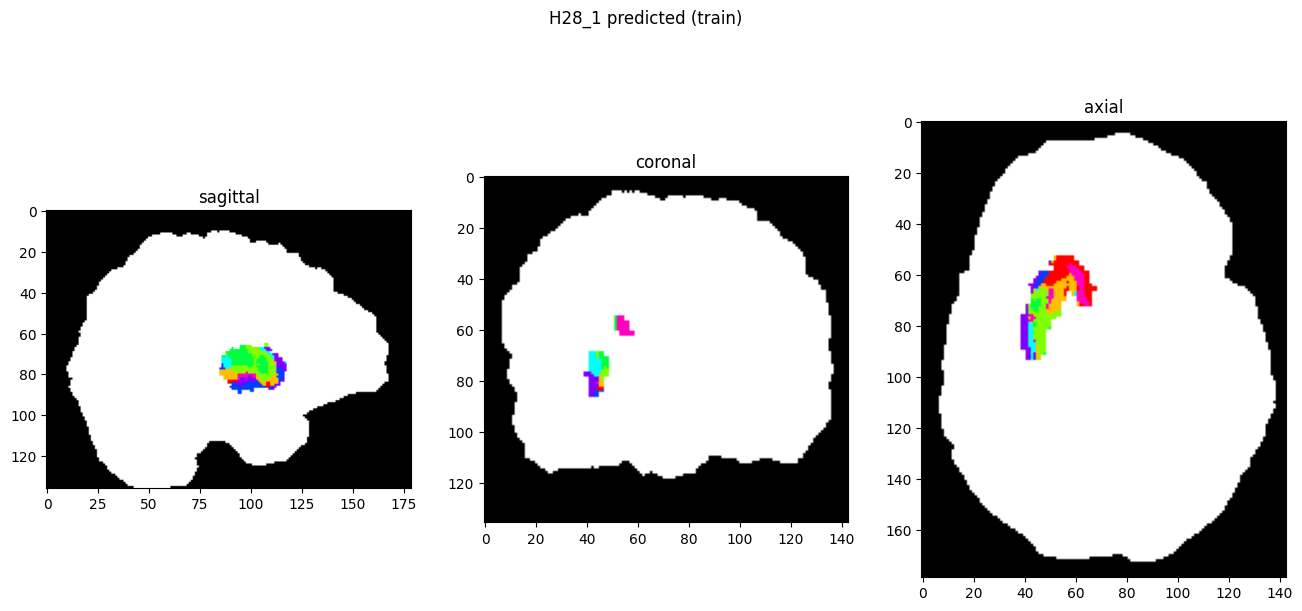

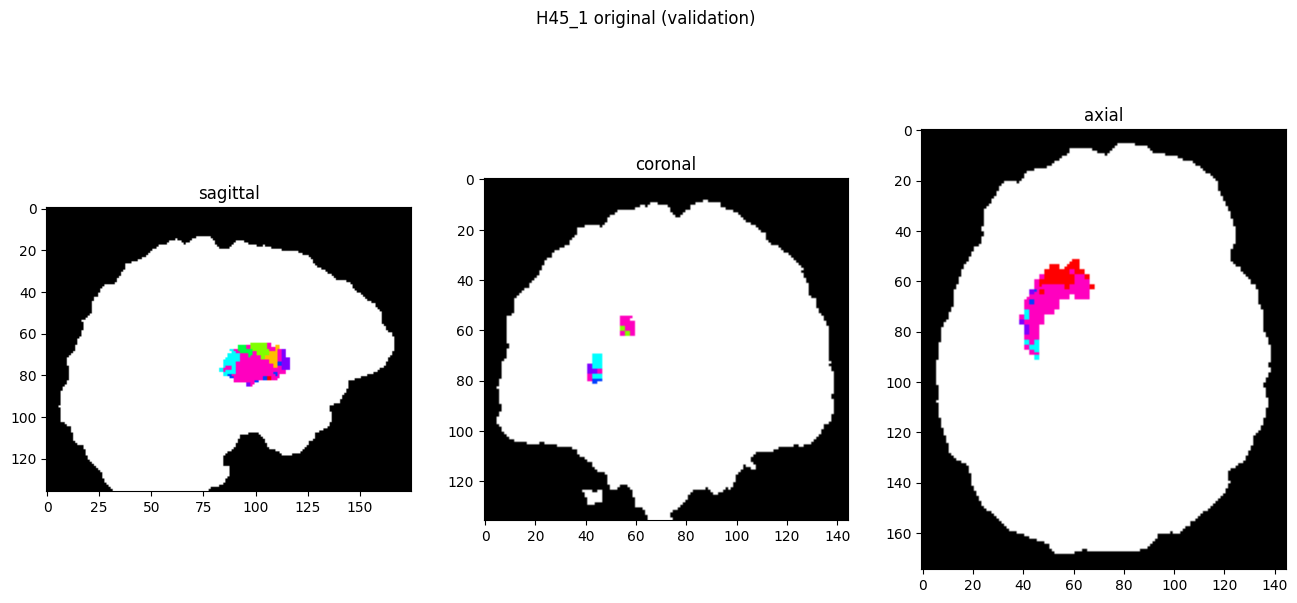

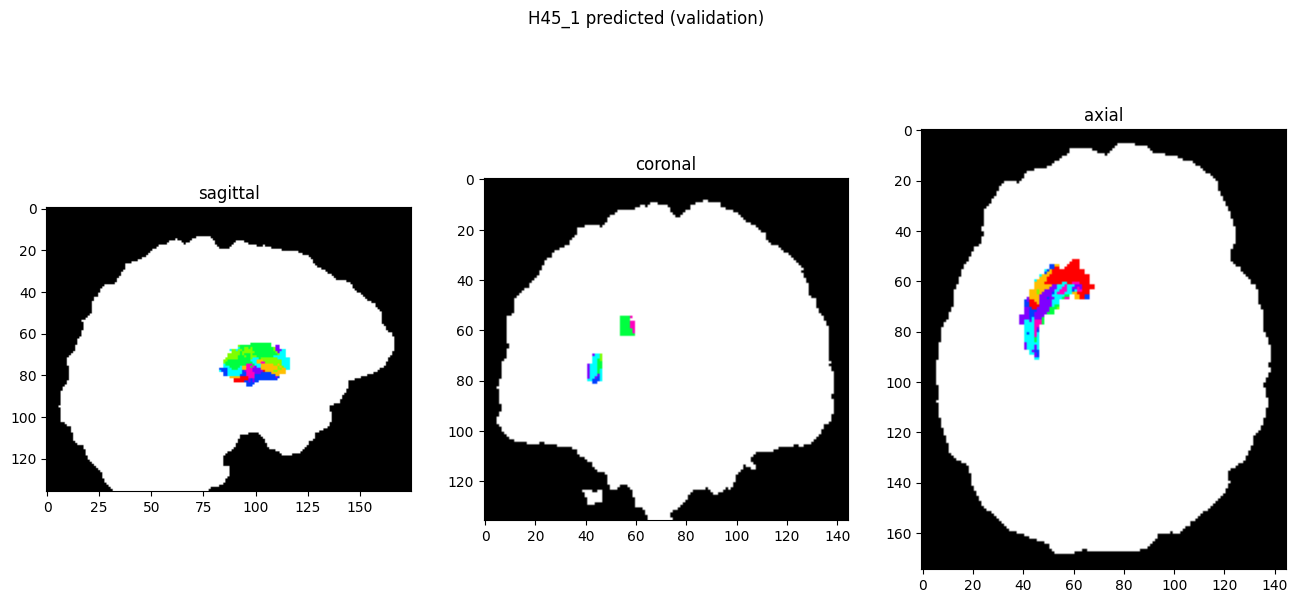

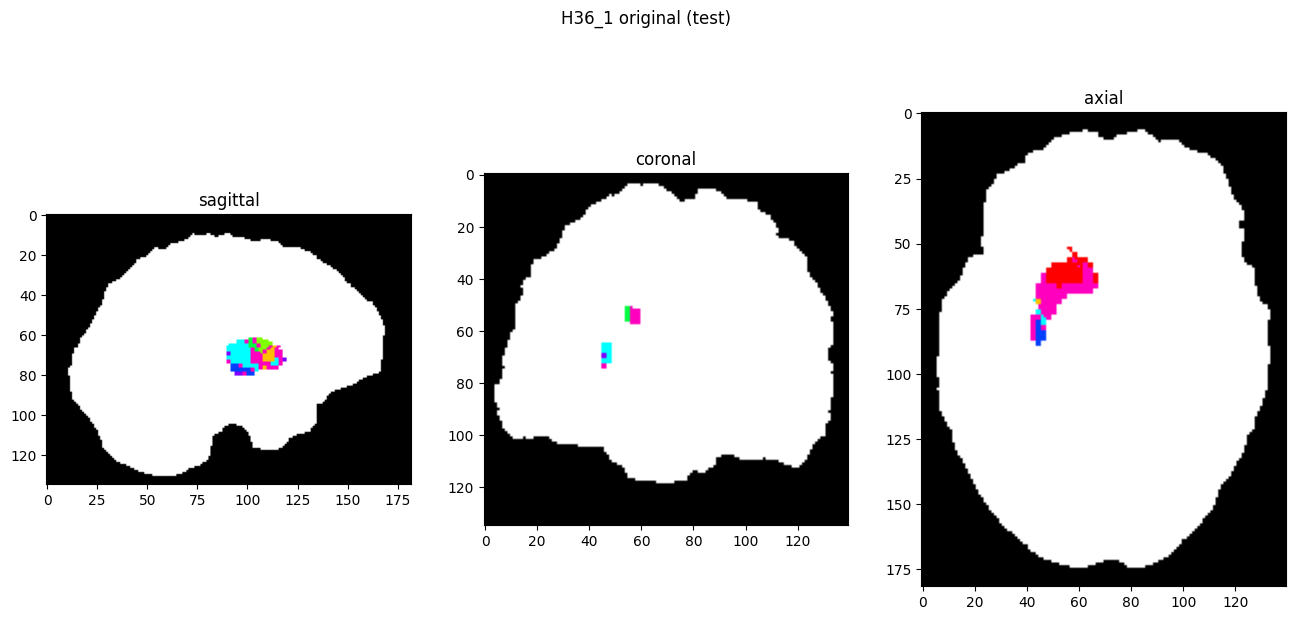

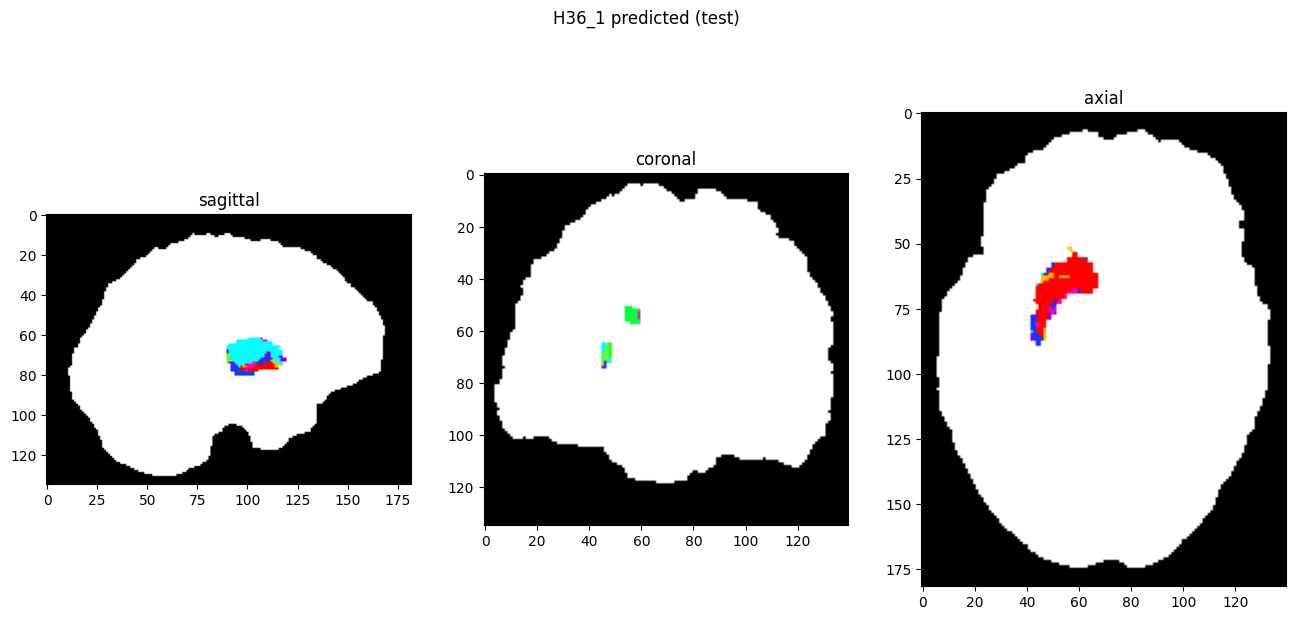

In [9]:
showResults(model, gen, threshold=0)